In [1]:
%matplotlib inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import xbout
import scipy
import xhermes

sys.path.append("/home/mike/work/sdtools")

from hermes3.utils import *

# import gridtools.solps_python_scripts.setup
# from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

import general.plotstyle



%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")

Done


## Read Hermes-3

In [2]:
db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
)

toload = [  
    # dict(name="base", id="m9ab-m9a_newmaster", unnormalise_geom = True, use_xhermes = True, squash = False), 
    dict(name="avg", id="m9ac-m9ab_core_average", unnormalise_geom = True, use_xhermes = True, squash = False), 
    dict(name="avg2", id="m9acb-core_average_morediags_lotstep", unnormalise_geom = True, use_xhermes = True, squash = False), 
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)
    cs[case["name"]].extract_2d_tokamak_geometry()


- Reading case m9ac-m9ab_core_average
-----------------------

Unnormalising with xHermes
- Reading case m9acb-core_average_morediags_lotstep
-----------------------

Unnormalising with xHermes


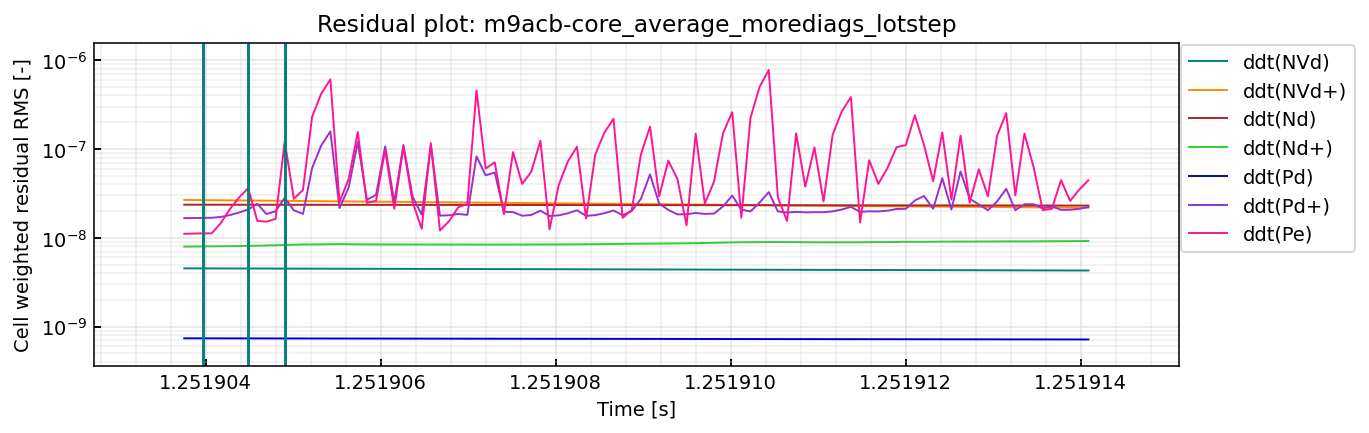

In [3]:
name = "avg2"
ds  = cs[name].ds.isel(t=slice(None,-1))

fig, ax = plt.subplots(figsize = (10,3))
plot_ddt(cs[name], ax = ax, trim_timestep = 1)


ds_slices = []
tind_slices = []

# time_slices = [0.4976125, 0.497615, 0.4976175, 0.49762]
# time_slices = [0.49762, 0.4976205, 0.4976208]
time_slices = [1.251904, 1.2519045, 1.2519049]

ylim = ax.get_ylim()

for time in time_slices:
    ds_1 = ds.sel(t = time, method = "nearest")
    tind_1 = ds_1["t"].values
    ax.vlines(tind_1, *ylim)
    
    ds_slices.append(ds_1)
    tind_slices.append(tind_1)
    
    
ax.set_ylim(ylim)
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))


KeyError: "No variable named 'ddtP_VgradP'. Did you mean one of ('Ed+_VgradP', 'Ee_VgradP')?"

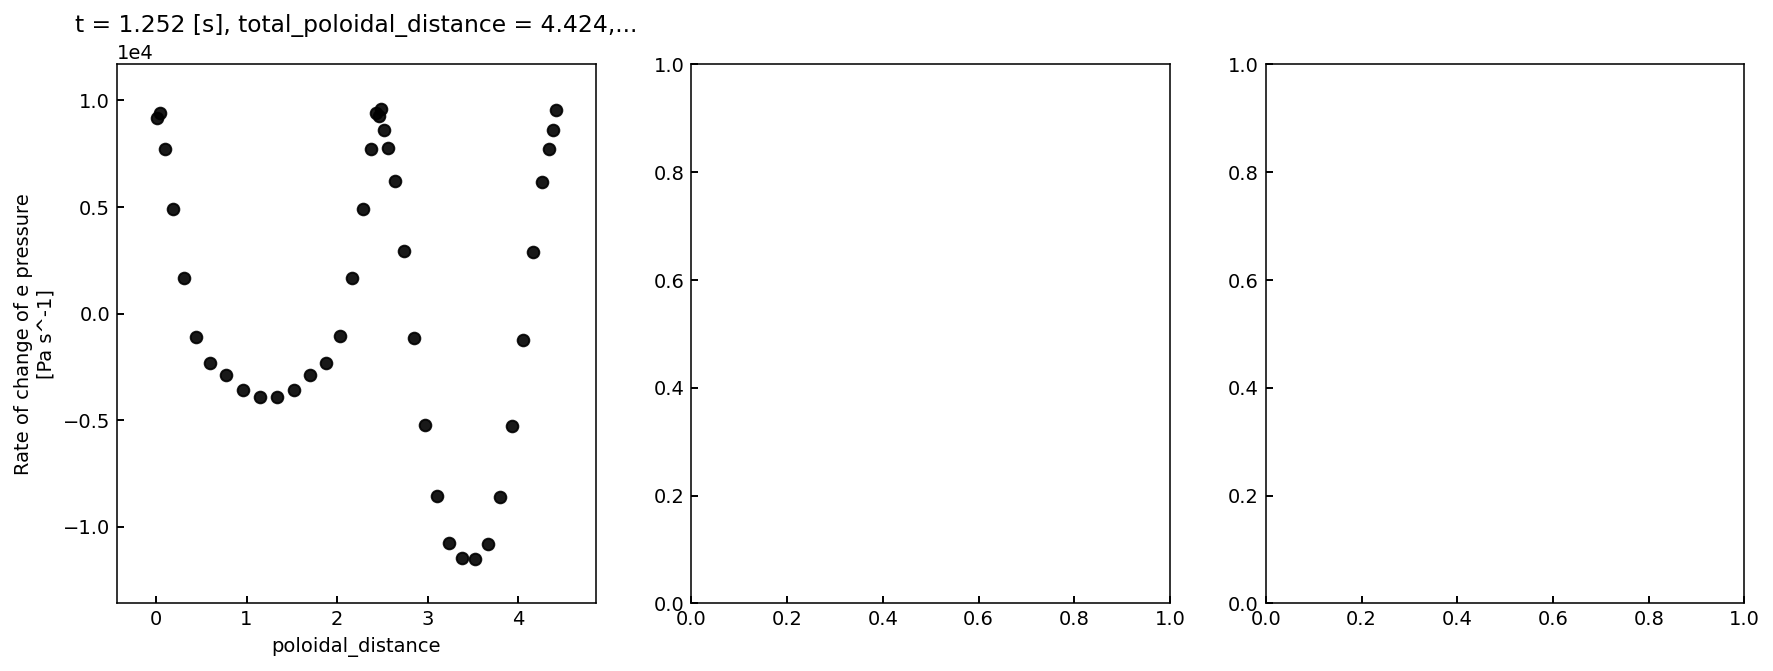

In [7]:
fig, axes = plt.subplots(1, len(time_slices), figsize = (5*len(time_slices),5))


for tind, t in enumerate(time_slices):

    ax = axes[tind]
    
    ds = cs[name].ds
    m = ds.metadata
    ixseps = m["ixseps1"]
    
    core = ds.hermesm.select_custom_core_ring(0)

    core["ddt(Pe)"].sel(t=t, method = "nearest").plot(ax = ax, x = "poloidal_distance", marker = "o", lw = 0, c = "k", alpha = 0.9,  label = "ddt(Pe)" if tind == 0 else None)
    
    # core["ddt(Pe)"].sel(t=t, method = "nearest").sel(theta = 20, method = "nearest").plot(ax = ax, x = "poloidal_distance", marker = "o", lw = 0, c = "k", alpha = 0.9,  label = "ddt(Pe)" if tind == 0 else None)

    core_sum = 0
    for param in ["ddtP_VgradP", "ddtP_advection", "ddtP_component_source", "ddtP_cond", "ddtP_viscousheat", "Pe_src"]:
        core[param].sel(t=t, method = "nearest").plot(ax = ax, x = "poloidal_distance", lw = 1, label = param if tind == 0 else None)
        core_sum += core[param].sel(t=t, method = "nearest")

    core_sum.plot(ax = ax, x = "poloidal_distance", lw = 0, marker = "o", c = "deeppink", ms = 5, label = "Sum" if tind == 0 else None)

    ax.set_title(f"ddt(Pe) decomposition, slice {tind}")
    
    ax.set_ylabel("Pa s^-1")
    ax.set_yscale("symlog", linthresh = 1e6)
    ax.set_ylim(-1e7, 1e7)
    
fig.legend(loc = "upper center", ncols = 8, bbox_to_anchor = (0.5, 0),fontsize = "medium")


In [ ]:
%matplotlib inline

In [ ]:
Te.sizes

Frozen({'x': 1, 'theta': 40})

In [ ]:
condflux.sizes

Frozen({'t': 101, 'x': 1, 'theta': 40})

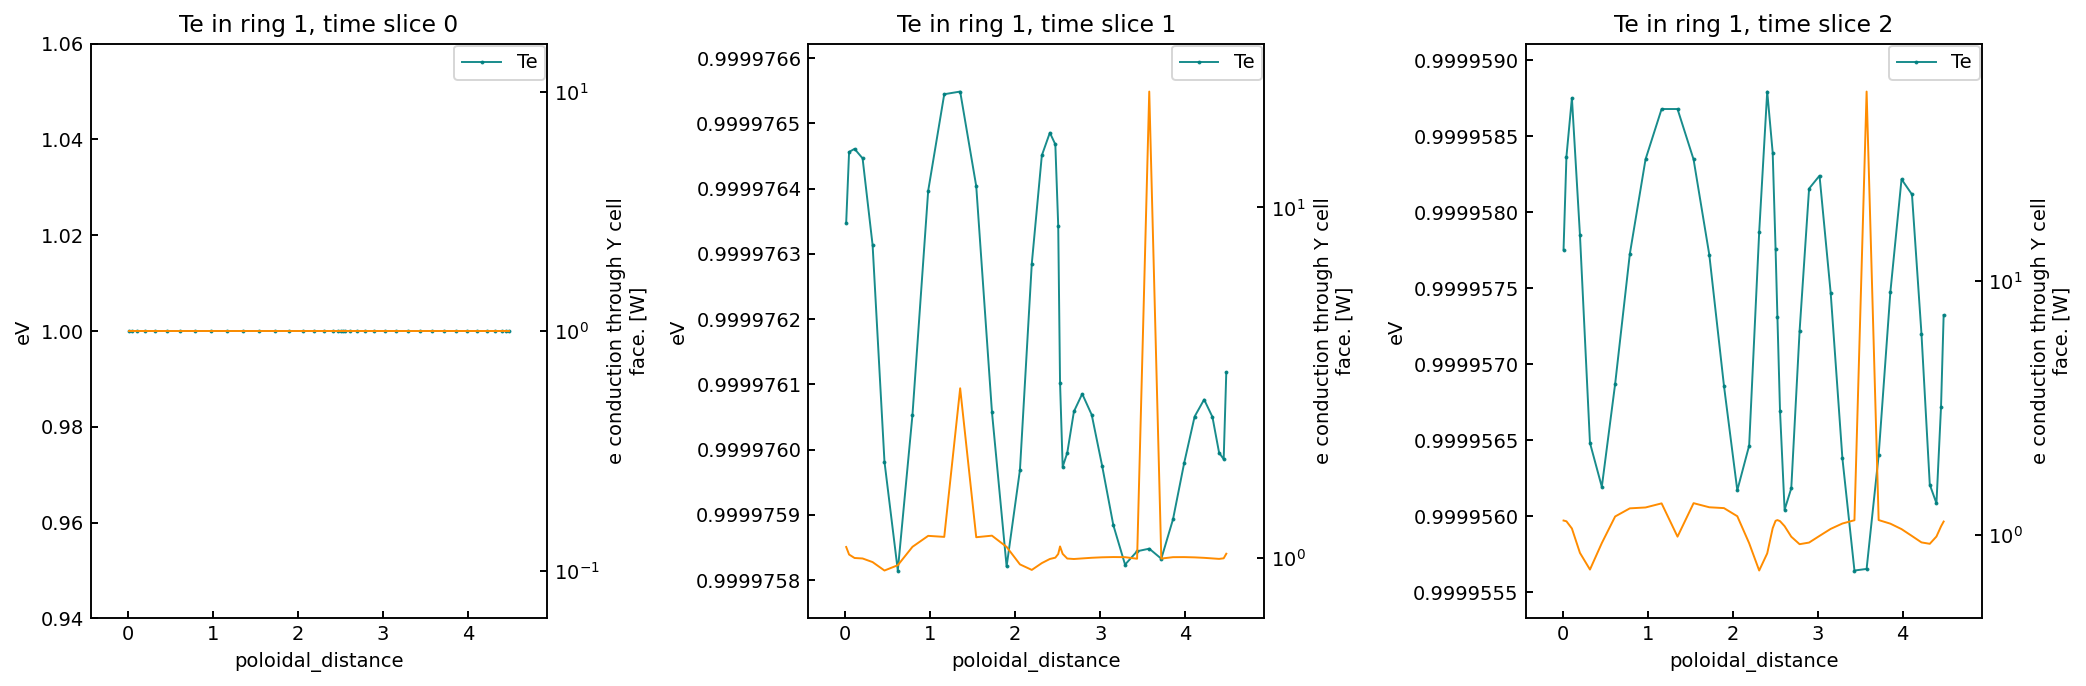

In [ ]:
ring_id = 1

name = "avg2"


fig, axes = plt.subplots(1, len(time_slices), figsize = (5*len(time_slices),5))

for tind, t in enumerate(time_slices):

    ax = axes[tind]
    ds = cs[name].ds
    m = ds.metadata
    ixseps = m["ixseps1"]

    core = ds.hermesm.select_custom_core_ring(ring_id).squeeze()
    Te = core["Te"].sel(t=t, method = "nearest")
    Te_0 = core["Te"].sel(t=time_slices[0], method = "nearest")
    Te_mean = Te.mean("theta")
    
    Te_timenorm = Te / Te_0 
    Te_norm = Te / Te_mean
    
    Te_timenorm.plot(ax = ax, x = "poloidal_distance", marker = "o", lw = 1, ms = 1,  alpha = 0.9, label = "Te")
    
    condflux = core["efe_cond_ylow"].sel(t=t, method = "nearest")
    condflux_0 = core["efe_cond_ylow"].sel(t=time_slices[0], method = "nearest")
    condflux_mean = condflux.mean("theta")
    condflux_timenorm = condflux / condflux_0
    condflux_norm = condflux / condflux_mean
    
    ax2 = ax.twinx()
    condflux_timenorm.plot(ax = ax2, x = "poloidal_distance", lw = 1, c = "darkorange", ms = 1, label = "condflux")
    ax2.set_title("")
    ax2.set_yscale("log")

    ax.set_title(f"Te in ring {ring_id}, time slice {tind}")
    ax.set_ylabel("eV")
    ax.legend()
    
fig.tight_layout()

In [5]:
%matplotlib widget

# Animation

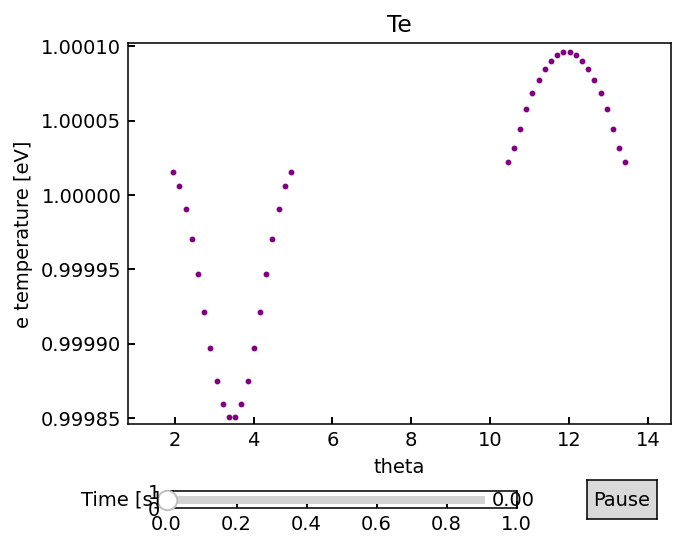

In [8]:
plt.close("all")

name = "avg2"
fig, ax = plt.subplots()

ds = cs[name].ds
m = ds.metadata
ixseps = m["ixseps1"]


core = ds.hermesm.select_custom_core_ring(2).squeeze()
Te = core["Te"].sortby("poloidal_distance")
Te_norm = Te / Te.mean("theta")
ddtPe = core["ddt(Pe)"].sortby("poloidal_distance")
ddtPe_norm = ddtPe / ddtPe.mean("theta")

xbout.plotting.animate.animate_line(Te_norm, ax =ax, lw = 0, ms = 2, c = "purple", marker = "o")

In [47]:
condflux_norm.sizes

Frozen({'theta': 40})

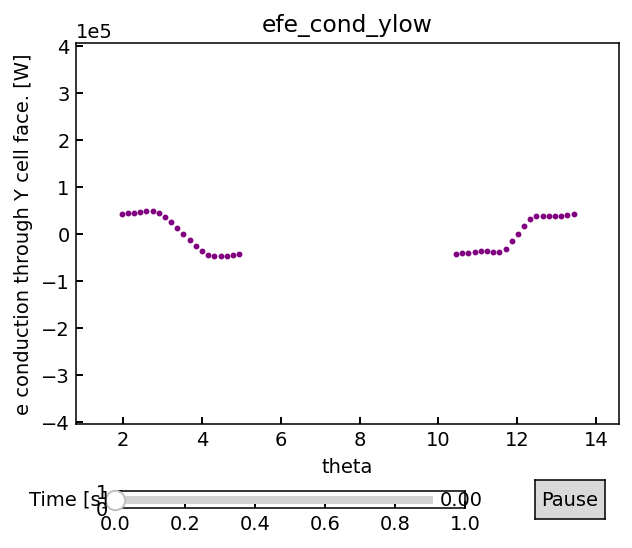

In [48]:
plt.close("all")

name = "avg2"
fig, ax = plt.subplots()

ds = cs[name].ds
m = ds.metadata
ixseps = m["ixseps1"]


core = ds.hermesm.select_custom_core_ring(2).squeeze()
condflux = core["efe_cond_ylow"]
condflux_mean = condflux.mean("theta")
condflux_norm = condflux / condflux_mean

xbout.plotting.animate.animate_line(condflux_norm, ax =ax, lw = 0, ms = 2, c = "purple", marker = "o")

/home/mike/pyenvs/base-3.12.5/lib/python3.12/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


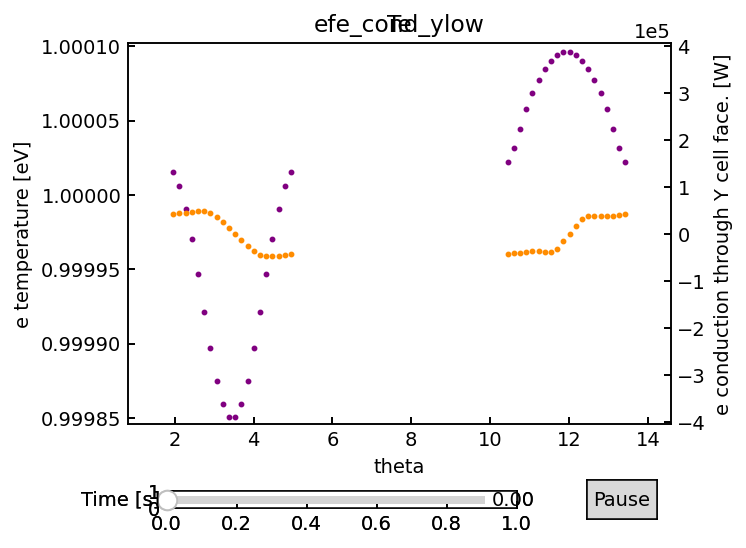

In [49]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

xbout.plotting.animate.animate_line(Te_norm, ax =ax, lw = 0, ms = 2, c = "purple", marker = "o")
xbout.plotting.animate.animate_line(condflux_norm, ax =ax2, lw = 0, ms = 2, c = "darkorange", marker = "o")

# 2D plots

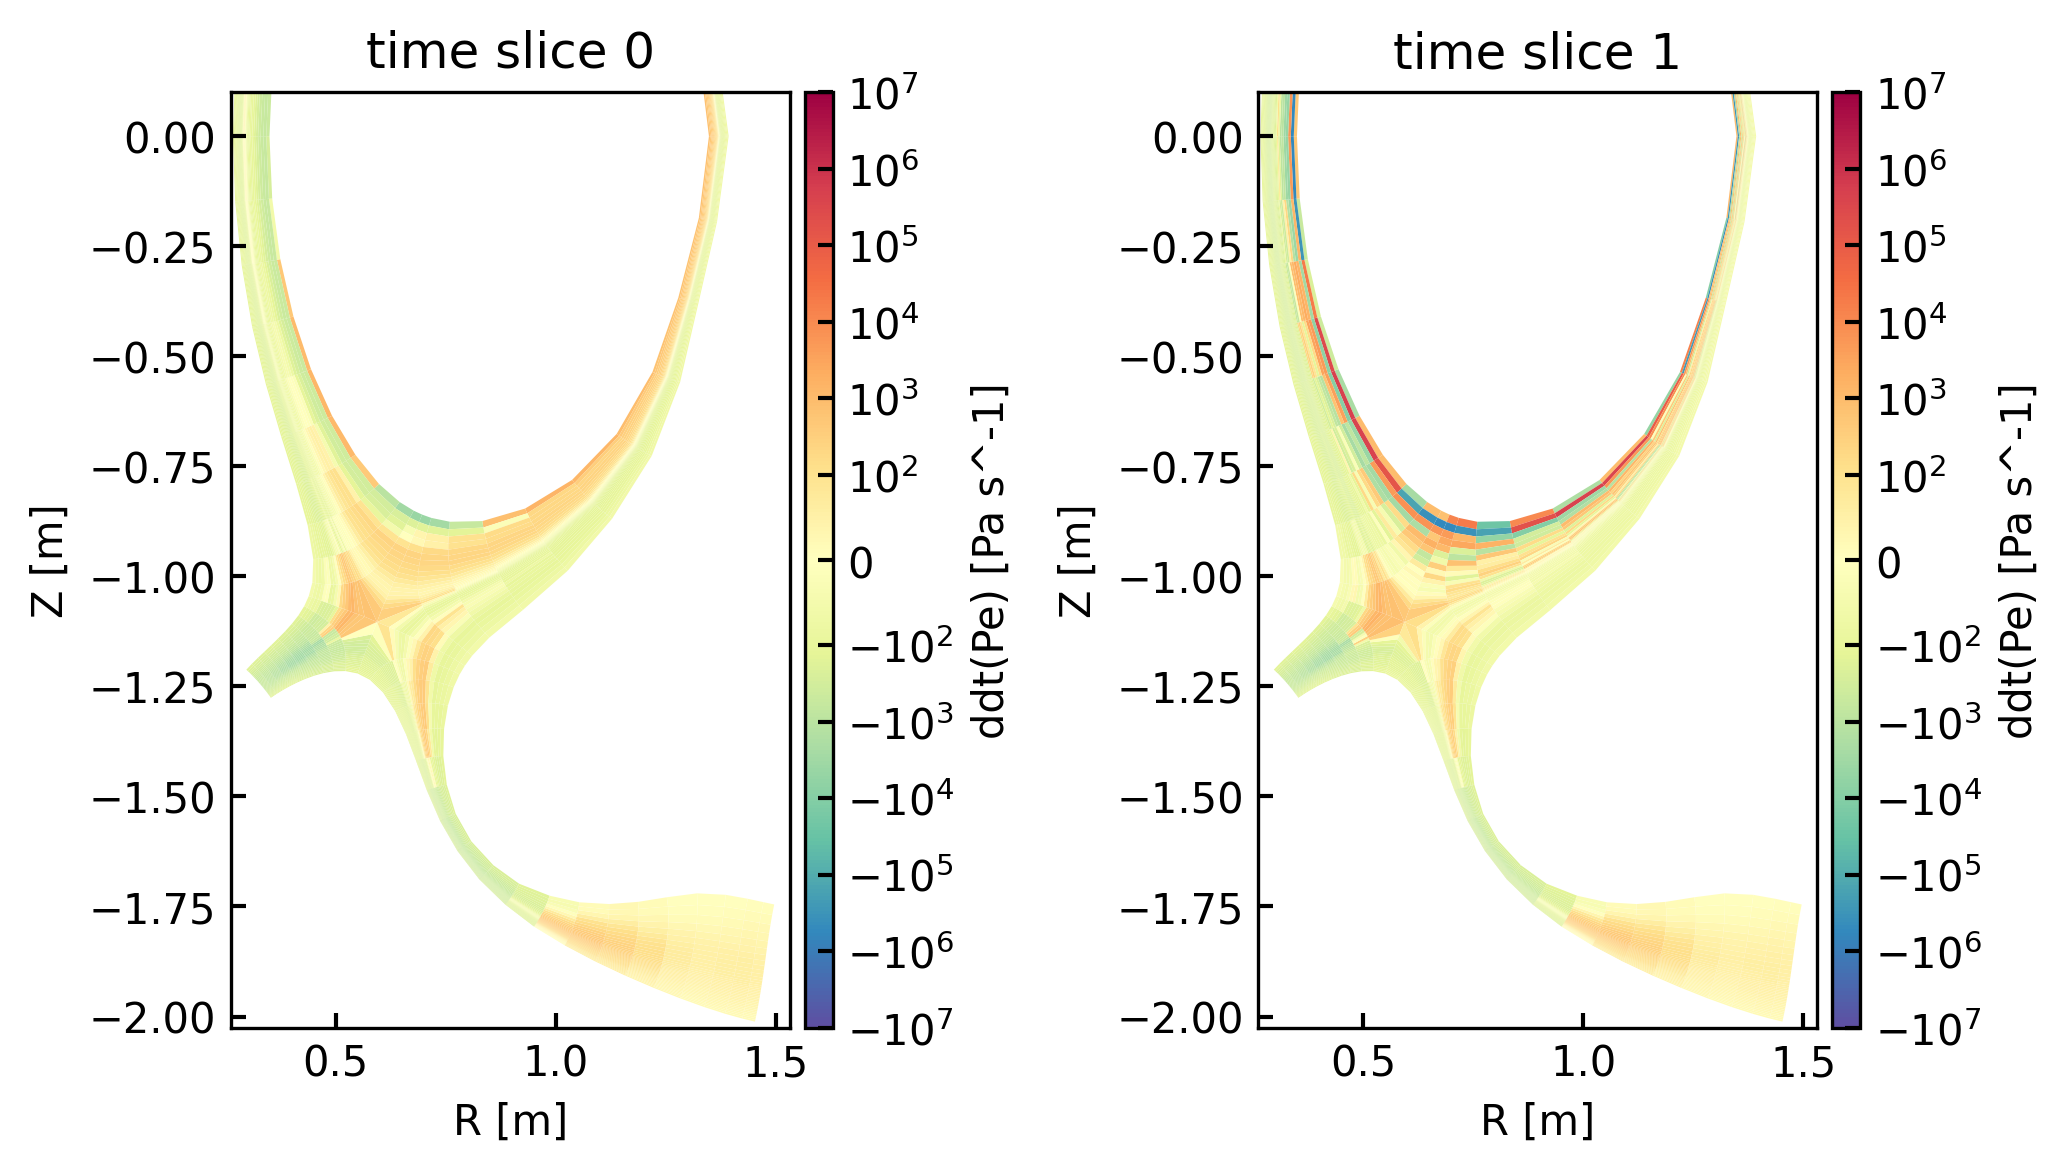

In [43]:
ds = cs["avg"].ds
no_times = len(tind_slices)
fig, axes = plt.subplots(1 ,no_times, figsize = (3.5*no_times, 5), dpi = 300)
style = dict(cmap = "Spectral_r", targets = False, separatrix_kwargs = dict(
    color="white", linestyle = "-", linewidth = 0),antialias = True,
             logscale = True)

for i, time in enumerate(tind_slices):
    
    ax = axes[i]
    ds["ddt(Pe)"].sel(t=time).hermesm.clean_guards().bout.polygon(ax = ax, vmin = -1e7, vmax = 1e7, **style)
    ax.set_title(f"time slice {i}")
    
    # ax = axes[1,i]
    # ds["ddtP_cond"].sel(t=time).hermesm.clean_guards().bout.polygon(ax = ax, vmin = -1e7, vmax = 1e7, **style)
    # ax.set_title(f"{i}")
    
    # ax = axes[2,i]
    # ds["ddt(NVd+)"].sel(t=time).hermesm.clean_guards().bout.polygon(ax = ax, vmin = -0.5, vmax = 0.5, **style)
    # ax.set_title(f"{i}")
    ax.set_ylim(None, 0.1)
    
fig.tight_layout()